<a href="https://colab.research.google.com/github/francesco-roscia/Multi-class-Weather-Classification-with-Artificial-Neural-Networks/blob/master/Weather_Conditions_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-class Weather Classification

## Import all packages and confirm tensorflow can see GPU

In [0]:
%tensorflow_version 1.x

from google.colab import drive

import keras
from keras import applications, optimizers, regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, AveragePooling2D,\
 Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Input, Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from tensorflow.keras.models import load_model


!apt-get -qq install -y graphviz
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

drive.mount('/content/drive')
datadir = '/content/drive/My Drive/Homework2/Dataset'
batch_size = 64

Found GPU at: /device:GPU:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data


In [0]:
trainingset = datadir + '/Training'
testset = datadir + '/Testing'

input_shape = ()
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=False,\
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(150, 240),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(150, 240),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))


Found 2000 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Image input (150, 240, 3)
Classes: ['HAZE', 'RAINY', 'SNOWY', 'SUNNY']
Loaded 2000 training samples from 4 classes.
Loaded 400 test samples from 4 classes.


## Show random image



SNOWY


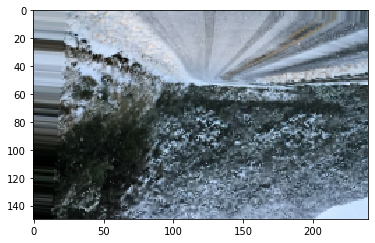

SUNNY


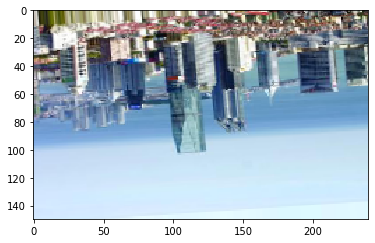

HAZE


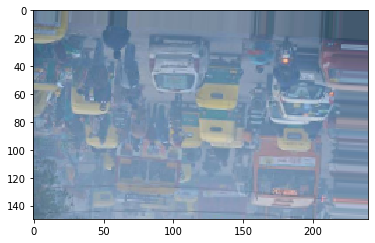

RAINY


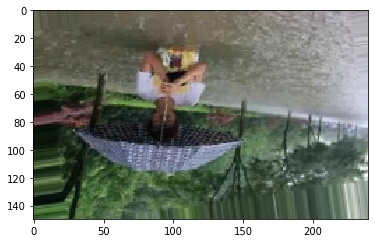

In [0]:
x,y = train_generator.next()
# x,y size is train_generator.batch_size

#indices will contains 4 indices to images of the 4 different classes
indeces = []
labels = []

for i in range(0, train_generator.batch_size):
  label = y[i].argmax() 
  if not (label in labels):
    indeces.append(i)
    labels.append(label)
  if len(indeces) == 4:
    break

for i in indeces:
    image = x[i]
    label = y[i].argmax()
    print(classnames[label])
    plt.imshow(image)
    plt.show()


## Define Convolutional Neural Network and train it from scratch

### CNN model














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "Frantz_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 59, 32)        3872      
_________________________________________________________________
average_pooling2d_1 (Average (None, 69, 55, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 69, 55, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 67, 53, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 25, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 25, 128)       512

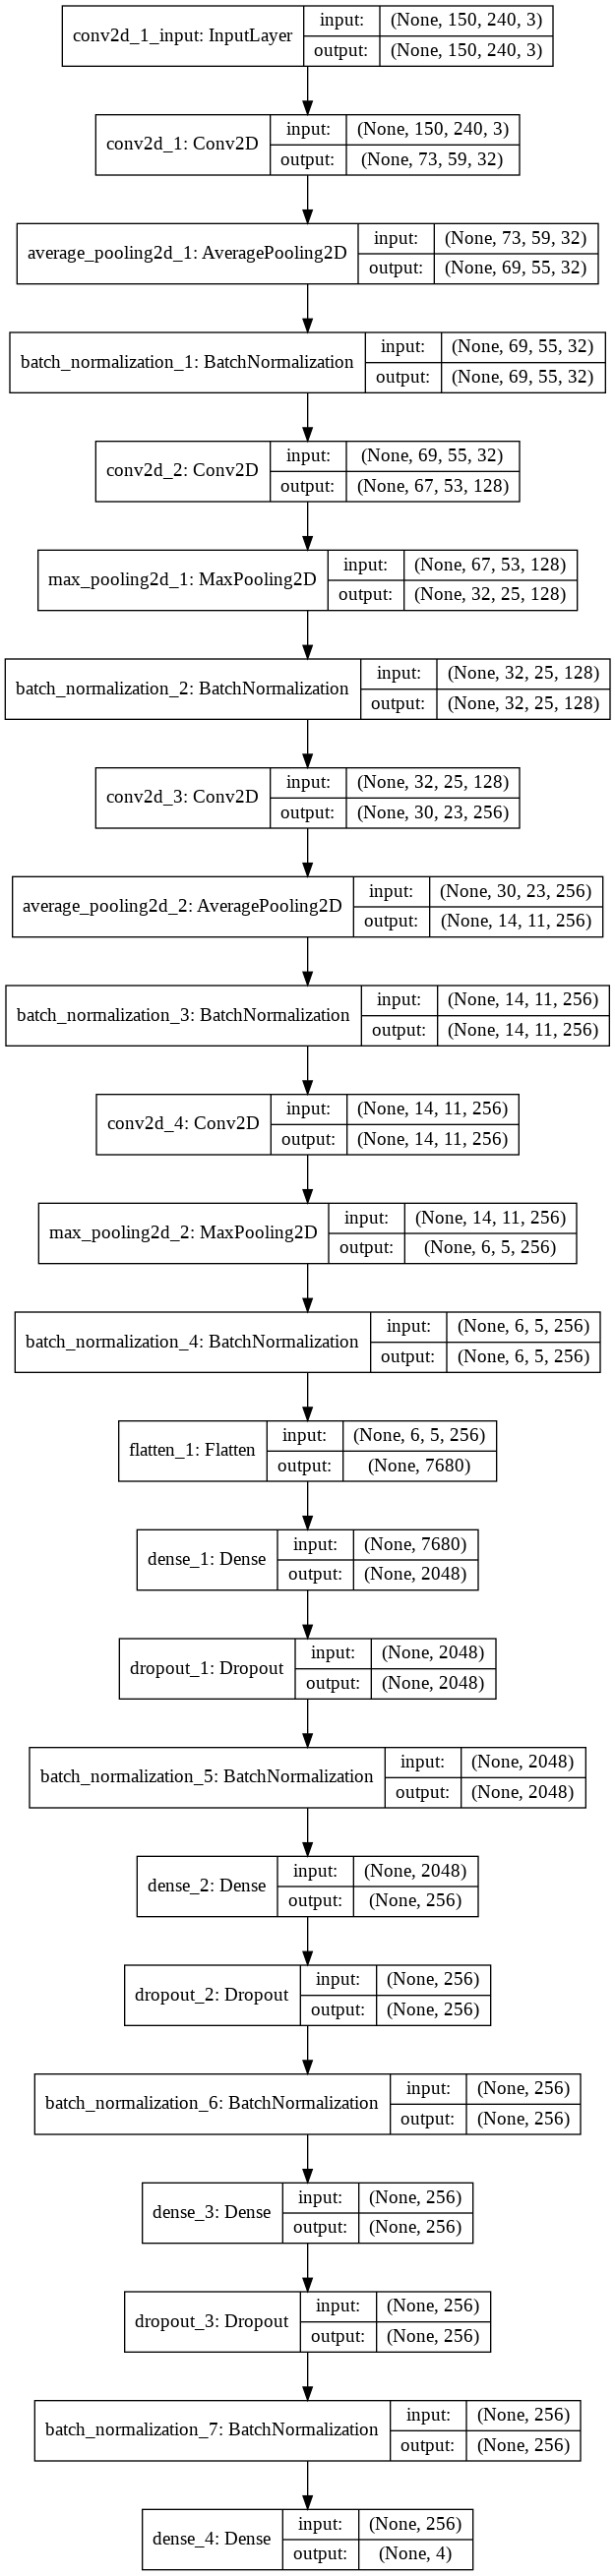

In [0]:
def Frantz_net(input_shape, num_classes):

    model = Sequential()
    model.name = 'Frantz_net'
    
    # C1 Convolutional Layer
    model.add(Conv2D(filters=32, input_shape=input_shape, kernel_size=(5,8),\
                     strides=(2,4), padding='valid', activation='tanh'))
    model.add(AveragePooling2D(pool_size=(5,5), strides=(1,1), padding='valid'))
    model.add(BatchNormalization())

    # C2 Convolutional Layer 
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1),\
                     padding='valid', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(5,5), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    # C3 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), \
                     padding='valid', activation='relu'))
    model.add(AveragePooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    # C4 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), \
                     padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())
    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)

    # D1 Dense Layer
    model.add(Dense(units=2048, input_shape=flatten_shape, \
                    activation='softplus'))
    # Dropout
    model.add(Dropout(0.333))
    model.add(BatchNormalization())

    # D2 Dense Layer
    model.add(Dense(units=256, activation='softplus'))
    model.add(Dropout(0.333))
    model.add(BatchNormalization())

    # D3 Dense Layer
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.333))
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(units=num_classes, activation='softmax'))

    # Compile
    model.compile(loss='categorical_crossentropy', \
                  optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

    return model
 
# create the model
model = Frantz_net(input_shape,num_classes)
model.summary()
plot_model(model, to_file='/content/drive/My Drive/Homework2/model_plot.png', show_shapes=True, show_layer_names=True)

### Train

In [0]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

try:
    history = model.fit_generator(train_generator, epochs=30, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass


model.save(modeldir+'Frantz_net.h5')

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


12/31 [==========>...................] - ETA: 36s - loss: 0.4351 - acc: 0.8190

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


24/31 [======================>.......] - ETA: 12s - loss: 0.4547 - acc: 0.8145

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


28/31 [==========================>...] - ETA: 5s - loss: 0.4751 - acc: 0.8125

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1048576 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


31/31 [==============================] - 52s 2s/step - loss: 0.4709 - acc: 0.8146 - val_loss: 0.8710 - val_acc: 0.7150
Epoch 2/30
31/31 [==============================] - 50s 2s/step - loss: 0.4604 - acc: 0.8276 - val_loss: 0.9983 - val_acc: 0.6275
Epoch 3/30
31/31 [==============================] - 50s 2s/step - loss: 0.4461 - acc: 0.8312 - val_loss: 1.5715 - val_acc: 0.4800
Epoch 4/30
31/31 [==============================] - 49s 2s/step - loss: 0.4740 - acc: 0.8181 - val_loss: 1.6922 - val_acc: 0.5350
Epoch 5/30
31/31 [==============================] - 50s 2s/step - loss: 0.5186 - acc: 0.7980 - val_loss: 0.9555 - val_acc: 0.6625
Epoch 6/30
31/31 [==============================] - 50s 2s/step - loss: 0.4408 - acc: 0.8347 - val_loss: 1.5365 - val_acc: 0.5775
Epoch 7/30
31/31 [==============================] - 49s 2s/step - loss: 0.4692 - acc: 0.8246 - val_loss: 1.9014 - val_acc: 0.5175
Epoch 8/30
31/31 [==============================] - 49s 2s/step - loss: 0.4355 - acc: 0.8331 - val_lo

### Evaluate the model

Precision, Recall, F1-score and Accuracy

In [0]:
preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes 

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames,\
                            digits=3))



7/7 [==============================] - 5s 719ms/step
              precision    recall  f1-score   support

        HAZE      0.549     0.670     0.604       100
       RAINY      0.511     0.700     0.591       100
       SNOWY      0.514     0.380     0.437       100
       SUNNY      0.836     0.560     0.671       100

    accuracy                          0.578       400
   macro avg      0.602     0.578     0.575       400
weighted avg      0.602     0.578     0.575       400



Confusion matrix analysis

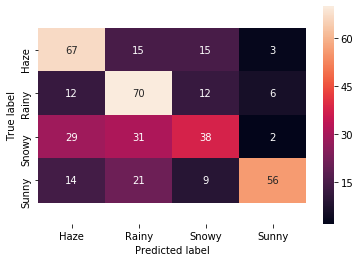

In [0]:
def plot_confusion_matrix(cm, classes):
    cm = pd.DataFrame(cm, index=classes, columns=classes)

    heatmap = sns.heatmap(cm, annot=True, fmt="d")
    bottom, top = heatmap.get_ylim()
    heatmap.set_ylim(bottom + 0.5, top - 0.5)
  
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = confusion_matrix(Ytest, Ypred)
classes = ['Haze', 'Rainy', 'Snowy', 'Sunny']

plot_confusion_matrix(cnf_matrix, classes)
plt.show()

### Plot results

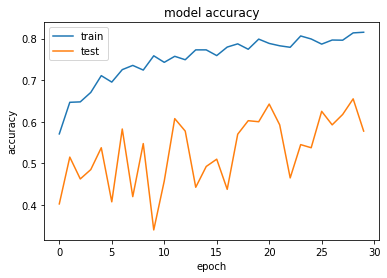

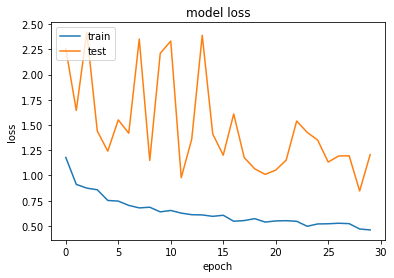

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Transfer learning

###Define a pre-trained model (InceptionResNetV2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1536)              54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 6148      
Total params: 54,342,884
Trainable params: 54,282,340
Non-trainable params: 60,544
_________________________________________________________________


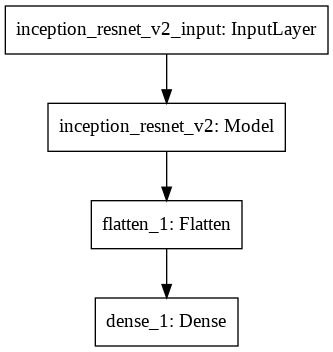

In [0]:
from keras.optimizers import Adam 

def Frantz_transfer_net(input_shape, num_classes):
  transfer_model = tf.keras.applications.InceptionResNetV2(\
    input_shape=input_shape,include_top=False, weights='imagenet', pooling='avg', classes=1000)

  model = tf.keras.Sequential([
    transfer_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
  optimizer = 'adam'
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    
  return model
    
transfer_model = Frantz_transfer_net(input_shape, num_classes)
transfer_model.summary()
tf.keras.utils.plot_model(transfer_model)

### Fit the model

In [0]:
steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = test_generator.n//test_generator.batch_size+1

try:
    history_transfer = transfer_model.fit_generator(train_generator, epochs=30,\
                    verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass
transfer_model.save(modeldir+'Frantz_transfer_net.h5')


Epoch 1/30


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


17/31 [===============>..............] - ETA: 1:26 - loss: 0.6719 - acc: 0.7592

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


23/31 [=====================>........] - ETA: 40s - loss: 0.6940 - acc: 0.7704

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1048576 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


25/31 [=======================>......] - ETA: 29s - loss: 0.6679 - acc: 0.7790

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


31/31 [==============================] - 147s 5s/step - loss: 0.6116 - acc: 0.7970 - val_loss: 12.5203 - val_acc: 0.2500
Epoch 2/30
31/31 [==============================] - 76s 2s/step - loss: 0.3132 - acc: 0.8874 - val_loss: 11.3292 - val_acc: 0.2100
Epoch 3/30
31/31 [==============================] - 76s 2s/step - loss: 0.2358 - acc: 0.9168 - val_loss: 4.7037 - val_acc: 0.4800
Epoch 4/30
31/31 [==============================] - 76s 2s/step - loss: 0.1955 - acc: 0.9246 - val_loss: 1.6499 - val_acc: 0.7025
Epoch 5/30
31/31 [==============================] - 78s 3s/step - loss: 0.1655 - acc: 0.9360 - val_loss: 2.2931 - val_acc: 0.6025
Epoch 6/30
31/31 [==============================] - 77s 2s/step - loss: 0.1600 - acc: 0.9437 - val_loss: 1.7172 - val_acc: 0.6650
Epoch 7/30
31/31 [==============================] - 74s 2s/step - loss: 0.1967 - acc: 0.9311 - val_loss: 3.3566 - val_acc: 0.5050
Epoch 8/30
31/31 [==============================] - 76s 2s/step - loss: 0.1367 - acc: 0.9561 - val

###Evaluate the model

Precision, Recall, F1-score and Accuracy

In [0]:
preds = transfer_model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes 

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames,\
                            digits=3))

7/7 [==============================] - 15s 2s/step
              precision    recall  f1-score   support

        HAZE      0.802     0.850     0.825       100
       RAINY      0.928     0.640     0.757       100
       SNOWY      0.770     0.940     0.847       100
       SUNNY      0.786     0.810     0.798       100

    accuracy                          0.810       400
   macro avg      0.822     0.810     0.807       400
weighted avg      0.822     0.810     0.807       400



Confusion matrix analysis

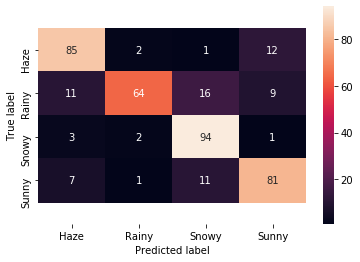

In [0]:
def plot_confusion_matrix(cm, classes):
    cm = pd.DataFrame(cm, index=classes, columns=classes)

    heatmap = sns.heatmap(cm, annot=True, fmt="d")
    bottom, top = heatmap.get_ylim()
    heatmap.set_ylim(bottom + 0.5, top - 0.5)
  
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = confusion_matrix(Ytest, Ypred)
classes = ['Haze', 'Rainy', 'Snowy', 'Sunny']

plot_confusion_matrix(cnf_matrix, classes)
plt.show()

###Plot results

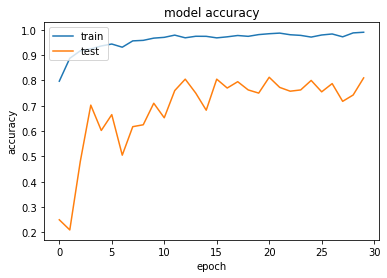

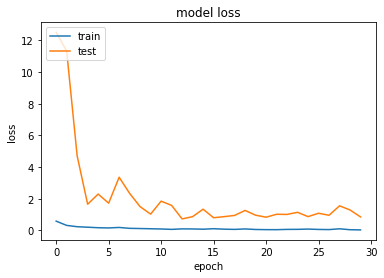

In [0]:
# summarize history for accuracy
plt.plot(history_transfer.history['acc'])
plt.plot(history_transfer.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_transfer.history['loss'])
plt.plot(history_transfer.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test and evaluation

In [0]:
# load the best model
model = load_model('/content/drive/My Drive/Homework2/ModelFrantz_transfer_net.h5')

print('Model loaded')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model loaded


###Evaluation on WeatherBlindTestSet

In [0]:
blind_set = datadir + '/Blind'

blind_datagen = ImageDataGenerator(
    rescale = 1. / 255)

blind_generator = blind_datagen.flow_from_directory(
    directory=blind_set,
    target_size=(150, 240),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

blind_pred = model.predict(blind_generator)
predictions = np.argmax(blind_pred, axis=1)

print('Prediction completed!')

def write_csv(pred):
  drive.mount('/content/drive')
  with open('/content/drive/My Drive/Homework2/1684483.csv', 'w') as csv:
    len_p = len(predictions)
    for i in range(0,len_p):
      data = predictions[i]
      if data == 0:
        csv.write('HAZE\n')
      elif data == 1:
        csv.write('RAINY\n')
      elif data == 2:
        csv.write('SNOWY\n')
      elif data == 3:
        csv.write('SUNNY\n')
  drive.flush_and_unmount()
  return 0

write_csv(predictions)

Found 1500 images belonging to 1 classes.
Model loaded!
Prediction completed!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


0

###Test on my pics

Found 16 images belonging to 4 classes.
1/1 [==============================] - 4s 4s/step
              precision    recall  f1-score   support

        HAZE      0.750     0.750     0.750         4
       RAINY      1.000     0.250     0.400         4
       SNOWY      0.500     0.750     0.600         4
       SUNNY      0.600     0.750     0.667         4

    accuracy                          0.625        16
   macro avg      0.713     0.625     0.604        16
weighted avg      0.713     0.625     0.604        16



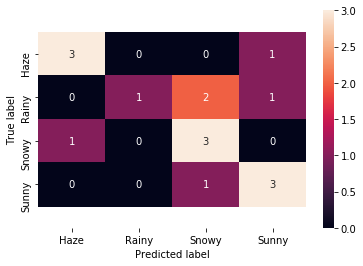

In [0]:
mypics_set = datadir + '/MyPics'

mypics_datagen = ImageDataGenerator(
    rescale = 1. / 255)

mypics_generator = mypics_datagen.flow_from_directory(
    directory=mypics_set,
    target_size=(150, 240),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

val_steps=mypics_generator.n//mypics_generator.batch_size+1

preds = model.predict_generator(mypics_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = mypics_generator.classes 

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames,\
                            digits=3))

def plot_confusion_matrix(cm, classes):
    cm = pd.DataFrame(cm, index=classes, columns=classes)

    heatmap = sns.heatmap(cm, annot=True, fmt="d")
    bottom, top = heatmap.get_ylim()
    heatmap.set_ylim(bottom + 0.5, top - 0.5)
  
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = confusion_matrix(Ytest, Ypred)
classes = ['Haze', 'Rainy', 'Snowy', 'Sunny']

plot_confusion_matrix(cnf_matrix, classes)
plt.show()

In [0]:
print(Ypred)
print(Ytest)

[0 0 0 3 3 1 2 2 2 0 2 2 2 3 3 3]
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
